In [1]:
## add the sys function part else there will be file loading errors.
import sys
import warnings
sys.path.insert(1,'../functions')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import numpy as np
import io_pipe
import nd_index
import lst
import plot_utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import logging
from eolearn.io import get_available_timestamps
import pdb
import geopandas as gpd

/Users/sanchit/anaconda3/lib/python3.7/site-packages/eolearn/io/processing_api.py:176: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ProcApiType("bool_mask", 'DN', 'UINT8', np.bool, FeatureType.MASK): [


In [3]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from sklearn.preprocessing import scale

/Users/sanchit/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.divide(0.4, 1, casting="unsafe", dtype=np.float),
/Users/sanchit/anaconda3/lib/python3.7/site-packages/scipy/fftpack/__init__.py:103: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/sanchit/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any

In [5]:
## add your sentinelhub credentials to start running this.
config_dict = {
            'INSTANCE_ID': None,
            'CLIENT_ID': None,
            'CLIENT_SECRET': None
        }

In [6]:
config_dict = {
            'INSTANCE_ID': '82f63741-572a-451c-905d-bd2575f2aad0',
            'CLIENT_ID': '4cac505f-9177-4874-ac2b-13c38b8ff178',
            'CLIENT_SECRET': ')5b0-PQyF%auI,8u>7Mv~^YhYJLMd_98Xe3>eeo5'
        }

In [7]:
vconfig = io_pipe.set_config(new_id=True,INSTANCE_ID=config_dict['INSTANCE_ID'],
                            CLIENT_ID= config_dict['CLIENT_ID'],
                            CLIENT_SECRET=config_dict['CLIENT_SECRET'])

In [8]:
year_range = range(2015,2017)
date_range = [1,30]
month_range = [6,9]

In [9]:
eopatch_data,vtimestamp = io_pipe.get_landsat8_range(config = vconfig,year_range=year_range,month=month_range,
                           date_range=date_range,maxcc=.2)

In [10]:
NDVI_REF = nd_index.calc_ndvi(eopatch_data)

In [11]:
B10 = eopatch_data[:,:,:,9]-273
B11 = eopatch_data[:,:,:,10]-273
#RADIANCE_ADD_BAND_10 = 0.10000
#RADIANCE_MULT_BAND_10 = 3.3420E-04
#K1_CONSTANT_BAND_10 = 774.8553
#K2_CONSTANT_BAND_10 = 1321.0789

In [12]:
vLSE = lst.LSE(NDVI_REF)
vLST = lst.mono_LST(B10,vLSE)

In [13]:
## use datamask for plot/NDVI/LST.
vR = eopatch_data[:,:,:,3]
vG = eopatch_data[:,:,:,2]
vB = eopatch_data[:,:,:,1]
vImg = np.stack([vR,vG,vB],axis =3)
vImg = (vImg *(255/  np.max(vImg))).astype(np.uint8)
vImg = (vImg*(3.5/255))

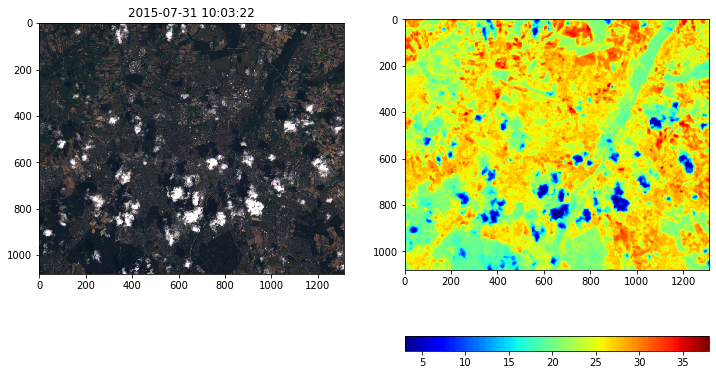

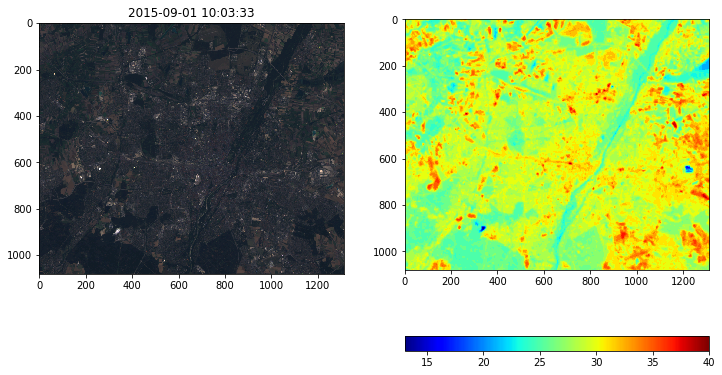

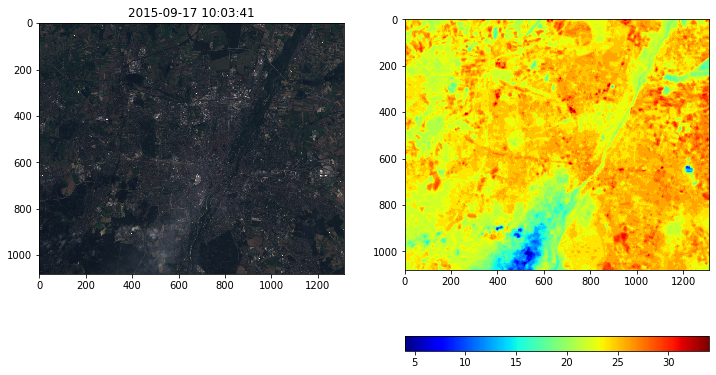

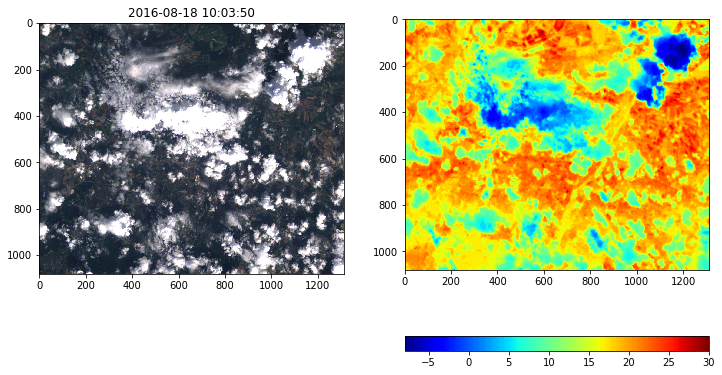

In [14]:
plot_utils.plot_all_LST(vImg,vLST,vtimestamp)

In [15]:
vdesired = vLST[1]

In [16]:
vgray = rgb2gray(vdesired)
vgray = scale(vgray,axis=0, with_mean=True, copy=True)

## Laplacian of Gaussian

In [17]:
blobs_log = blob_log(vgray, max_sigma=15, num_sigma=9, threshold=.1)

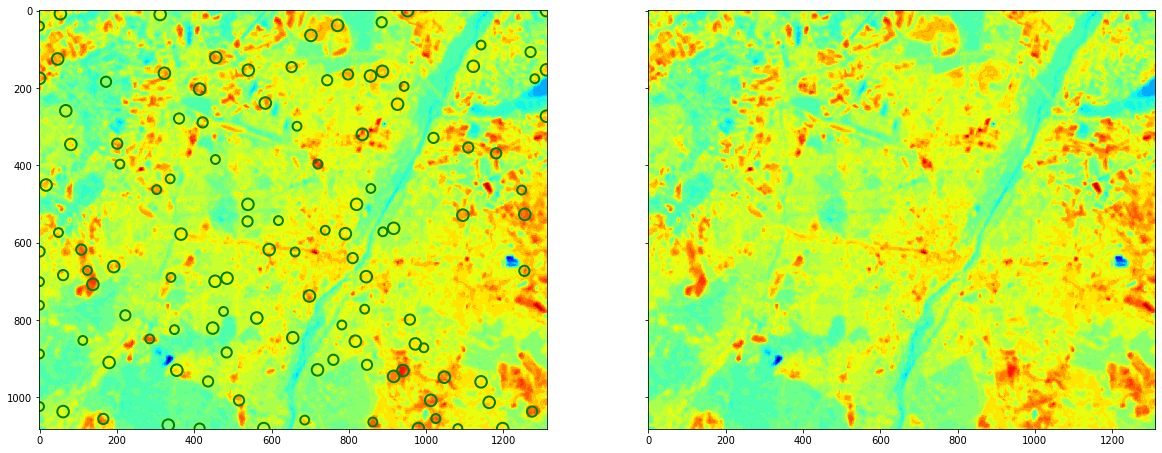

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
#plt.imshow(vLST[0],cmap='gray')
ax[0].imshow(vdesired,cmap=plt.cm.jet)
for blob in blobs_log:
    y, x, r = blob
    if r>10:
        c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
        ax[0].add_patch(c)
ax[1].imshow(vdesired,cmap=plt.cm.jet)
plt.show()

## Difference of Gaussian (DoG)

In [23]:
blobs_dog = blob_dog(vgray, max_sigma=9, threshold=.1)

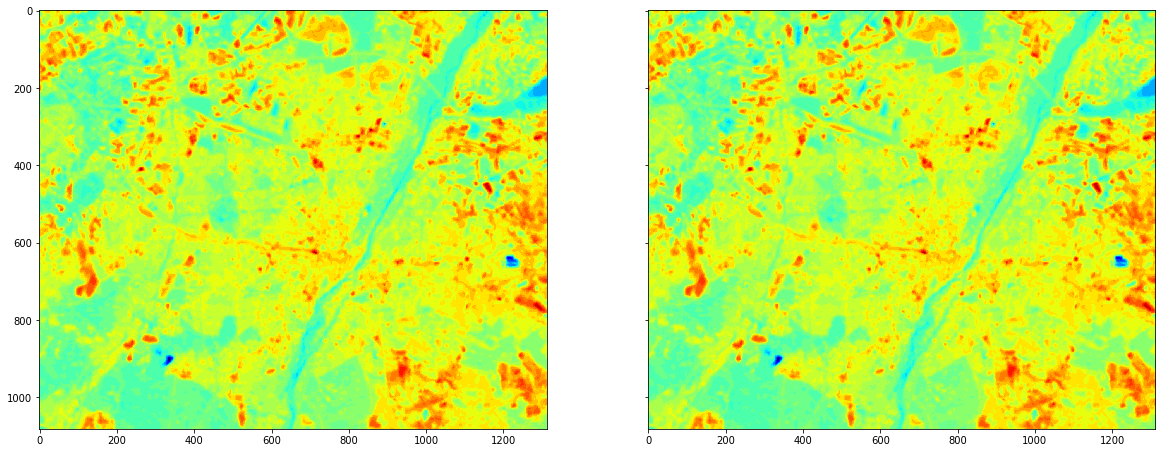

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
#plt.imshow(vLST[0],cmap='gray')
ax[0].imshow(vdesired,cmap=plt.cm.jet)
for blob in blobs_dog:
    y, x, r = blob
    if r>8:
        c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
        ax[0].add_patch(c)
ax[1].imshow(vdesired,cmap=plt.cm.jet)
plt.show()

## Determinant of Hessian (DoH)¶

In [19]:
blobs_doh = blob_doh(vgray, max_sigma=9, threshold=.1)

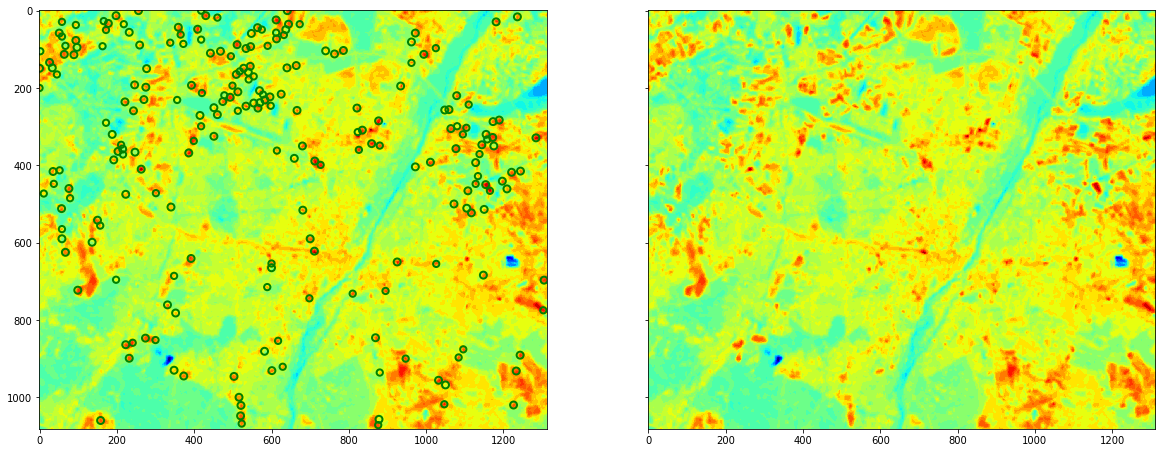

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
#plt.imshow(vLST[0],cmap='gray')
ax[0].imshow(vdesired,cmap=plt.cm.jet)
for blob in blobs_doh:
    y, x, r = blob
    if r>8:
        c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
        ax[0].add_patch(c)
ax[1].imshow(vdesired,cmap=plt.cm.jet)
plt.show()